In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import signal
import math

In [2]:
# Define model function to be used to fit to a vertical slice
def gauss(x, *p):
  A, mu, sigma = p
  return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [3]:
# filename               -> relative file path of FITS file containing raw 2D spectrum
# ref_wavelength_1_x     -> x for ref_wavelength_1
# ref_wavelength_2_x     -> x for ref_wavelength_2
# wavelength1 (optional) -> lower bound of wavelength bucket used for analysis (defaults to 4000 Å)
# wavelength2 (optional) -> upper bound of wavelength bucket used for analysis (defaults to 7000 Å)
# bin_size (optional)    -> Vertical slice used to compute sky background / gaussian profile
def compute_fwhm_data(filename,
                      ref_wavelength_1_x,
                      ref_wavelength_2_x,
                      ref_wavelength_1=3948,
                      ref_wavelength_2=7032,
                      wavelength1=4000,
                      wavelength2=7000,
                      bin_size=50):
  # We are going to assume a simple linear calibration law:
  #   wavelength = x * rate + offset
  #   i.e., x = (wavelength - offset) / rate

  # Determine the `rate` and `offset` parameters using a calibration image:
  rate = (ref_wavelength_2 - ref_wavelength_1) / (ref_wavelength_2_x - ref_wavelength_1_x)
  offset = 3948 - 527 * rate

  # Slice of the image to extract, expressed in pixels.
  #
  #                x1                     x2
  #                |                      |
  #   ----------------------------------------------------
  #   /////////////|                      |///////////////
  #   /////////////|                      |///////////////
  #   /////////////|                      |///////////////
  #

  # Now, let's calculate x1 and x2 so that we cover the entire visible range, i.e. ~ 400 - 700 nm
  x1 = math.floor((wavelength1 - offset) / rate)
  x2 = math.ceil((wavelength2 - offset) / rate)

  # Load the image data:
  image = fits.open(filename)
  imageData = image[0].data

  # Apply a median filter with a kernel size of 3 to fix hot/cold pixels:
  cleanImageData = signal.medfilt2d(imageData, kernel_size=3)

  # Extract a vertical slice of the image:
  sliceData = cleanImageData[:, x1:x2]

  # Prepare a list to receive the FWHM values:
  width = len(sliceData[0])
  height = len(sliceData)
  fwhmData = [0] * width

  # Iterate over each column
  for columnIndex in np.arange(width):
    columnValues = sliceData[:, columnIndex]

    # Get position of the spectrum (where the value is maximum)
    maxIndex = np.argmax(columnValues)

    # Note about bin_size...
    # What part of the image around the 2D spectrum should we ignore when computing
    # the mean background value? Which part of the image around the 2D spectrum
    # should we use to fit a Gaussian curve? This is parameterized by bin_size,
    # which is expressed in pixels. If bin_size is 20, the signal part of the image
    # will be +20px / -20px around the spectrum, for a total window height of 40px.
    #
    #  ////////////////////////////////////////////
    #  ///////////// background sky ///////////////
    #  -------------------------------------------- <- y0 - bin_size
    #
    #
    #  ******************************************** <- 2D spectrum (y0)
    #
    #
    #  -------------------------------------------- <- y0 + bin_size
    #  ///////////// background sky ///////////////
    #  ////////////////////////////////////////////
    #

    # Get background value
    background = np.concatenate((columnValues[ : maxIndex-bin_size], columnValues[maxIndex + bin_size : ]))
    backgroundValue = np.mean(background, axis=0)
    # print(f"Background value is {backgroundValue}")

    # Subtract the background
    columnValues = np.subtract(columnValues, backgroundValue)

    # Get the maximum value:
    maxValue = columnValues[maxIndex]

    # Extract the useful part of the image, the one that contains only the 2D spectrum
    spectrum = columnValues[maxIndex - bin_size : maxIndex + bin_size]

    # Update maxIndex accordingly...
    maxIndex = np.argmax(spectrum)

    xdata = np.arange(len(spectrum))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [maxValue, maxIndex, 3]
    coeff, var_matrix = curve_fit(gauss, xdata, spectrum, p0=p0)
    A, mu, sigma = coeff

    fwhmData[columnIndex] = 2 * sigma # 2x because we want the FWHM

  fwhmData_smooth = signal.savgol_filter(fwhmData, 80, 3)

  # Normalize the data
  min = np.min(fwhmData_smooth)
  normalized = fwhmData_smooth / min

  return normalized

In [4]:
def calculate_score(fwhmData):
  return len(fwhmData) / np.sum(fwhmData)

In [5]:
def get_fwhm_for_wavelength(fwhmData,
                            wavelength,
                            wavelength1=4000,
                            wavelength2=7100):
  step = len(fwhmData) / (wavelength2 - wavelength1)
  index = math.floor((wavelength - wavelength1) * step)
  return fwhmData[index]

Longitudinal CA score (the higher — up to 1.0 — the better):
RC10 -> 0.89


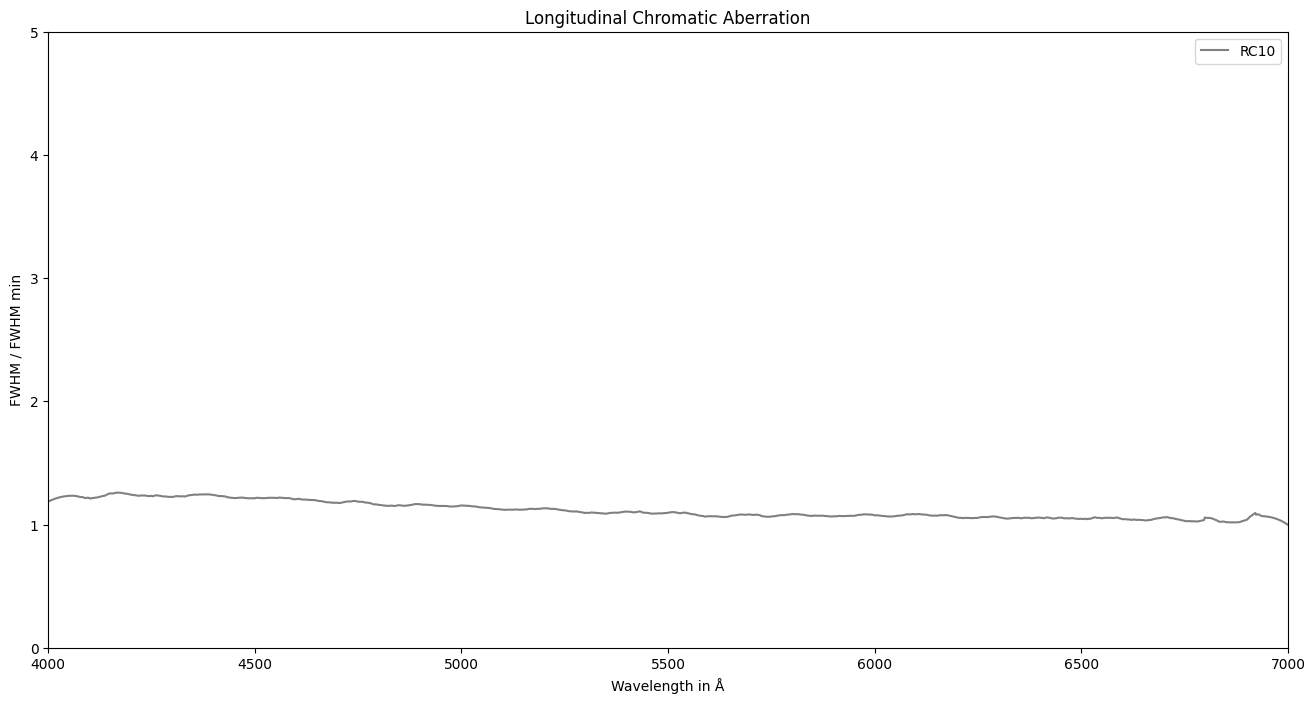

In [6]:
rc10_fwhmData = compute_fwhm_data(
  filename="data/RC10/SSCyg.fits",
  ref_wavelength_1_x=414,   # 4047 Å ->  414 pixels
  ref_wavelength_2_x=1865,  # 6300 Å -> 1865 pixels
  ref_wavelength_1 = 4047,
  ref_wavelength_2 = 6300,
)

# Graph the data...

step = (7000 - 4000) / len(rc10_fwhmData)
xdata = np.arange(4000, 7000, step)

plt.figure(figsize=(16, 8))
plt.title("Longitudinal Chromatic Aberration")
plt.plot(xdata, rc10_fwhmData, label="RC10", color='gray')
plt.xlabel("Wavelength in Å")
plt.ylabel("FWHM / FWHM min")
plt.xlim(4000, 7000)
plt.ylim(0, 5)
plt.legend();

# Calculate scores...

print("Longitudinal CA score (the higher — up to 1.0 — the better):")
print(f"RC10 -> {calculate_score(rc10_fwhmData):.2f}")

Longitudinal CA scores (the higher — up to 1.0 — the better):
AT130EDT -> 0.57
AT130EDT + Astronomik L3 -> 0.60


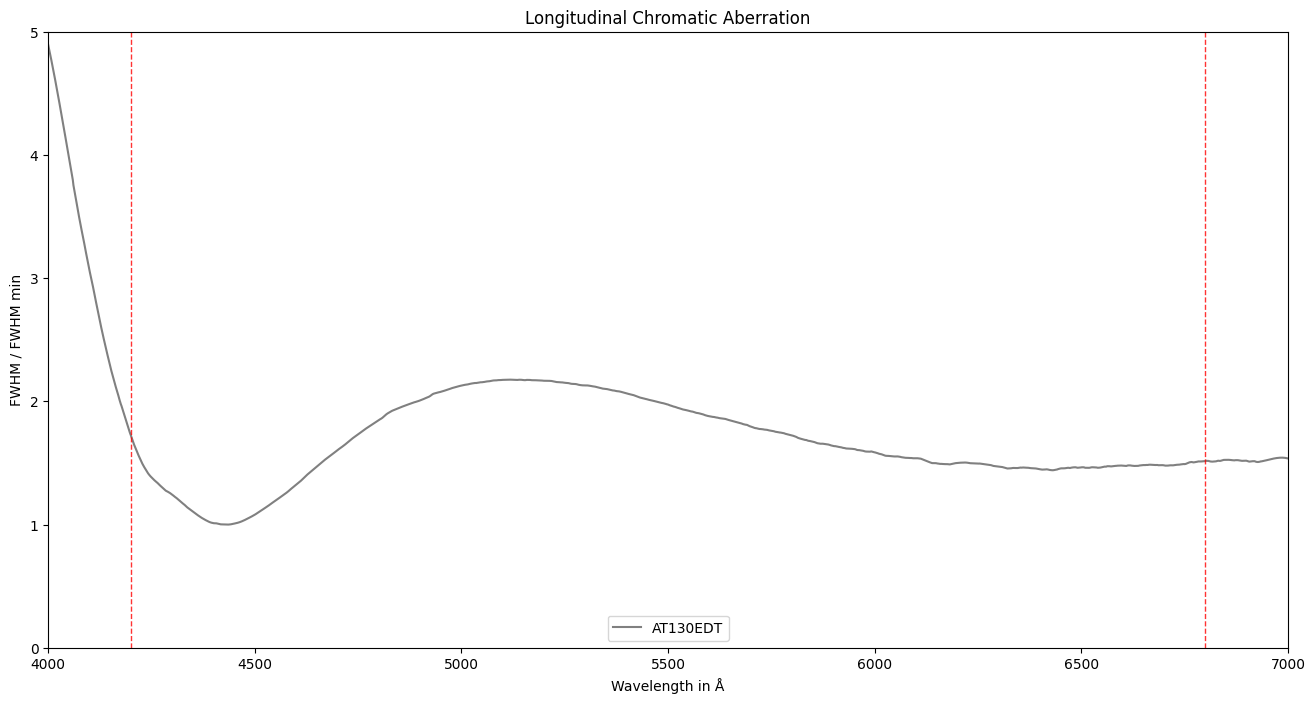

In [7]:
at130edt_visible_fwhmData = compute_fwhm_data(
  filename="data/AT130EDT/thetaLeo.fits",
  ref_wavelength_1_x=527,   # 3948 Å ->  527 pixels
  ref_wavelength_2_x=2541,  # 7032 Å -> 2541 pixels
)

at130edt_astronomik_l3_fwhmData = compute_fwhm_data(
  filename="data/AT130EDT/thetaLeo.fits",
  ref_wavelength_1_x=527,   # 3948 Å ->  527 pixels
  ref_wavelength_2_x=2541,  # 7032 Å -> 2541 pixels
  wavelength1=4200,         # 4200 Å
  wavelength2=6800,         # 6800 Å
)

# Graph the data...

step = (7000 - 4000) / len(at130edt_visible_fwhmData)
xdata = np.arange(4000, 7000, step)

plt.figure(figsize=(16, 8))
plt.title("Longitudinal Chromatic Aberration")
plt.plot(xdata, at130edt_visible_fwhmData, label="AT130EDT", color='gray')
plt.xlabel("Wavelength in Å")
plt.ylabel("FWHM / FWHM min")
plt.xlim(4000, 7000)
plt.ylim(0, 5)
plt.legend()

plt.axvline(x=4200, color='r', linestyle='--', linewidth=1.0, alpha=0.8)
plt.axvline(x=6800, color='r', linestyle='--', linewidth=1.0, alpha=0.8);

# Calculate scores...

print("Longitudinal CA scores (the higher — up to 1.0 — the better):")
print(f"AT130EDT -> {calculate_score(at130edt_visible_fwhmData):.2f}")
print(f"AT130EDT + Astronomik L3 -> {calculate_score(at130edt_astronomik_l3_fwhmData):.2f}")

Longitudinal CA scores (the higher — up to 1.0 — the better):
Askar 151 PHQ -> 0.64
Askar 151 PHQ + Astronomik L3 -> 0.68


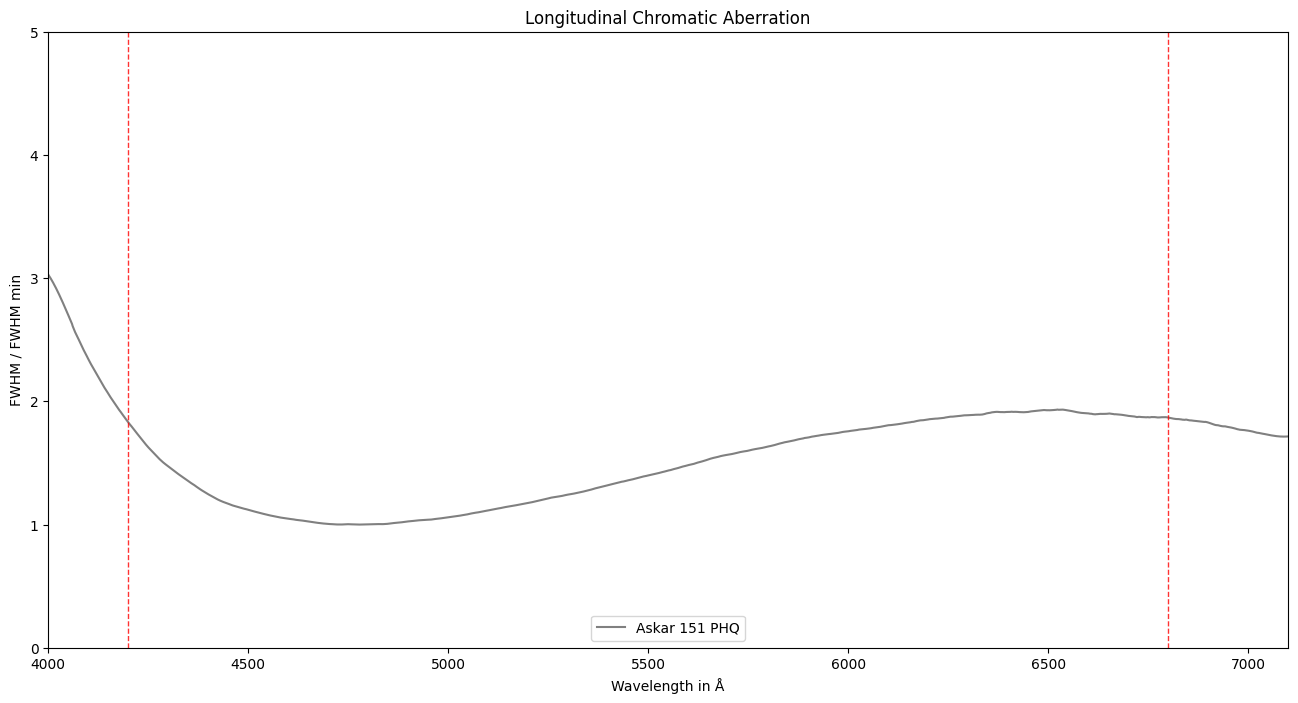

In [8]:
askar151phq_visible_fwhmData = compute_fwhm_data(
  filename="data/Askar151PHQ/alphaPeg.fits",
  ref_wavelength_1_x=546,   # 3948 Å ->  527 pixels
  ref_wavelength_2_x=2560,  # 7032 Å -> 2541 pixels
  wavelength2=7100,         # 7100 Å
)

askar151phq_astronomik_l3_fwhmData = compute_fwhm_data(
  filename="data/Askar151PHQ/alphaPeg.fits",
  ref_wavelength_1_x=546,   # 3948 Å ->  527 pixels
  ref_wavelength_2_x=2560,  # 7032 Å -> 2541 pixels
  wavelength1=4200,         # 4200 Å
  wavelength2=6800,         # 6800 Å
)

# Graph the data...

step = (7100 - 4000) / len(askar151phq_visible_fwhmData)
xdata = np.arange(4000, 7100, step)

plt.figure(figsize=(16, 8))
plt.title("Longitudinal Chromatic Aberration")
plt.plot(xdata, askar151phq_visible_fwhmData, label="Askar 151 PHQ", color='gray')
plt.xlabel("Wavelength in Å")
plt.ylabel("FWHM / FWHM min")
plt.xlim(4000, 7100)
plt.ylim(0, 5)
plt.legend()

plt.axvline(x=4200, color='r', linestyle='--', linewidth=1.0, alpha=0.8)
plt.axvline(x=6800, color='r', linestyle='--', linewidth=1.0, alpha=0.8);

# Calculate scores...

print("Longitudinal CA scores (the higher — up to 1.0 — the better):")
print(f"Askar 151 PHQ -> {calculate_score(askar151phq_visible_fwhmData):.2f}")
print(f"Askar 151 PHQ + Astronomik L3 -> {calculate_score(askar151phq_astronomik_l3_fwhmData):.2f}")

Blue FWHM = 1.472966157321811
Green FWHM = 1.481364124779306
Red FWHM = 1.7416515543265279


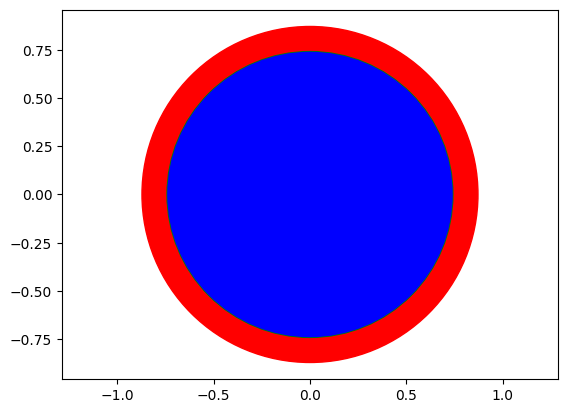

In [9]:
# Attempt to create the same spot diagram for the Askar 151PHQ as the one advertised...

blue_fwhm = get_fwhm_for_wavelength(askar151phq_visible_fwhmData, 4300)
green_fwhm = get_fwhm_for_wavelength(askar151phq_visible_fwhmData, 5600)
red_fwhm = get_fwhm_for_wavelength(askar151phq_visible_fwhmData, 7030)

print(f"Blue FWHM = {blue_fwhm}")
print(f"Green FWHM = {green_fwhm}")
print(f"Red FWHM = {red_fwhm}")

fig = plt.figure()
ax = fig.add_subplot()

circle_blue = plt.Circle((0, 0), blue_fwhm/2, color='blue')
circle_green = plt.Circle((0, 0), green_fwhm/2, color='green')
circle_red = plt.Circle((0, 0), red_fwhm/2, color='red')

ax.add_patch(circle_red)
ax.add_patch(circle_green)
ax.add_patch(circle_blue)

ax.axis('equal');